# Using Classic ML to Predict Alzheimer's Disease from eGEMAPS Features: a Comparison of Segment Aggregation Methods and Majority Voting

In this notebook, we use 88 pre-generated acoustic features extracted from each audio segment using the eGeMAPSv02 parameter set. These features include pitch, formants, speech rate, and other key acoustic markers, are thought to be indicative of cognitive decline and are used to train machine learning models for Alzheimer’s Disease (AD) diagnosis. The features were generated using the **OpenSMILE** package, a widely used toolkit for audio feature extraction.

Using these features, we explore standard ML techniques including:
* Dimension reduction: PCA, PLS, LDA
* Classification models: XGBoost, Random Forest, SVM, Logistic Regression
* Ordinal Regression 
* Clustering: KMeans
* Data augmentation: SMOTE

Most importantly, each participant’s dataset consists of approximately 30 seconds of audio, which was segmented into 0.2-second intervals. For each segment, eGeMAPSv2 features were extracted. The primary challenge is to determine how to aggregate segment-level features into subject-level representations for prediction. This aggregation is crucial for building a robust machine learning model for AD diagnosis. Thus, we explore and compare different approaches for segment aggregation, including the following:

**1. Early Fusion**:  In this approach, we aggregate segment-level features into subject-level features before training a machine learning model. Several aggregation techniques are evaluated:

- **Average of Segment-Level Features**: The mean value of features across all segments for a given subject.
- **Standard Deviation of Segment-Level Features**: The variability of features across segments, providing information about consistency within a subject’s audio.
- **Clustering of Segment-Level Features**: Grouping segment-level features into clusters and using the cluster centroids as subject-level features.

**2. Late Fusion**:  Here, we train segment-level classification models first and then aggregate the predictions from each segment to make a final subject-level prediction. Techniques include:

- **Majority Voting**: The final prediction for a subject is based on the majority class from the segment-level predictions (mean or median).
  
These approaches are akin to **ensemble learning**, where multiple models or predictions are combined to improve the overall performance.


## Part 1: Setup

In [42]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from scipy.stats import uniform, randint
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [15]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [3]:
VAL_SIZE = 0.2 
DATA_DIR = "" 
SUB_DIR = "submission"

## Part 2: Load Data

In [4]:
# load raw data
train = pd.read_csv("original/train_features.csv", index_col=0)
train_y = pd.read_csv("original/train_labels.csv", index_col=0)
test = pd.read_csv("original/test_features.csv", index_col=0)
metadata = pd.read_csv("original/metadata.csv", index_col=0)
ss = pd.read_csv("original/submission_format.csv", index_col=0)

metadata = metadata[["gender", "age"]]
metadata['gender'] = metadata['gender'].replace({'male': 0, 'female': 1})

train = train.merge(metadata, on="uid", how="left")
test = test.merge(metadata, on="uid", how="left")

train.shape, test.shape, metadata.shape

/var/folders/gv/3zqh7pw57f340f93mh5tvkl40000gn/T/ipykernel_65849/160026665.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metadata['gender'] = metadata['gender'].replace({'male': 0, 'female': 1})


((445706, 92), (111068, 92), (2058, 2))

## Part 3: Early Fusion: Compute Averaged Feature across Segments

### 3.1. Data preparation

In [5]:
covariates = ['gender', 'age']

In [6]:
# average feature across segments 
train_by_uid = train.drop(["segment_start_sec", "segment_end_sec"], axis=1).groupby("uid").median()
test_by_uid = test.drop(["segment_start_sec", "segment_end_sec"], axis=1).groupby("uid").median()

# number of unique patients
patients = train_by_uid.index.tolist()
print(f"There are {len(patients)} unique patients")

# check missing value
if 'uid' in train_y.columns:
    train_y.set_index("uid", inplace=True)
    
print("Missing data:", train_by_uid.isna().sum().sum())
train_by_uid.shape, test_by_uid.shape

# add std features
train_by_uid_std = train.drop(["segment_start_sec", "segment_end_sec"], axis=1).groupby("uid").std()
test_by_uid_std = test.drop(["segment_start_sec", "segment_end_sec"], axis=1).groupby("uid").std()
train_by_uid_std.drop(covariates, axis=1, inplace=True)
test_by_uid_std.drop(covariates, axis=1, inplace=True)
test_by_uid_std.columns = [col+"_std" for col in test_by_uid_std.columns]
train_by_uid_std.columns = [col+"_std" for col in train_by_uid_std.columns]
train_by_uid = train_by_uid_std.merge(train_by_uid, on="uid", how="left")
test_by_uid = test_by_uid_std.merge(test_by_uid, on="uid", how="left")

# add min features
# train_by_uid_min = train.drop(["segment_start_sec", "segment_end_sec"], axis=1).groupby("uid").std()
# test_by_uid_min = test.drop(["segment_start_sec", "segment_end_sec"], axis=1).groupby("uid").std()
# train_by_uid_min.drop(covariates, axis=1, inplace=True)
# test_by_uid_min.drop(covariates, axis=1, inplace=True)
# test_by_uid_min.columns = [col+"_min" for col in test_by_uid_min.columns]
# train_by_uid_min.columns = [col+"_min" for col in train_by_uid_min.columns]
# train_by_uid = train_by_uid_min.merge(train_by_uid, on="uid", how="left")
# test_by_uid = train_by_uid_min.merge(test_by_uid, on="uid", how="left")

# add max features
# train_by_uid_max = train.drop(["segment_start_sec", "segment_end_sec"], axis=1).groupby("uid").std()
# test_by_uid_max = test.drop(["segment_start_sec", "segment_end_sec"], axis=1).groupby("uid").std()
# train_by_uid_max.drop(covariates, axis=1, inplace=True)
# test_by_uid_max.drop(covariates, axis=1, inplace=True)
# test_by_uid_max.columns = [col+"_max" for col in test_by_uid_max.columns]
# train_by_uid_max.columns = [col+"_max" for col in train_by_uid_max.columns]
# train_by_uid = train_by_uid_max.merge(train_by_uid, on="uid", how="left")
# test_by_uid = train_by_uid_max.merge(test_by_uid, on="uid", how="left")
train_by_uid.shape, test_by_uid.shape

There are 1646 unique patients
Missing data: 0


((1646, 178), (412, 178))

### 3.2. Preprocessing

In [ ]:
# remove outliers (optional)
# Q1 = train_by_uid.quantile(0.01)
# Q3 = train_by_uid.quantile(0.99)
# IQR = Q3 - Q1

# print("Original dataframe:")
# print(train_by_uid.shape)

# # Filter the DataFrame by removing rows with outliers (values outside 1.5 * IQR)
# index = ((train_by_uid < (Q1 - 1.5 * IQR)) | (train_by_uid > (Q3 + 1.5 * IQR))).any(axis=1)
# train_by_uid = train_by_uid[~index]
# train_y = train_y[~index]

# print("DataFrame without outliers (IQR method):")
# print(train_by_uid.shape)

In [8]:
# train test split
patients = train_by_uid.index.tolist()
print(f"There are {len(patients)} unique patients")

train_patients, val_patients = train_test_split(patients, test_size=VAL_SIZE, random_state=42)
test_patients = test_by_uid.index.tolist()

X_train = train_by_uid.loc[train_patients]
X_val = train_by_uid.loc[val_patients]
X_test = test_by_uid
X_train_all = train_by_uid

y_train = np.asarray(train_y.loc[train_patients])
y_val = np.asarray(train_y.loc[val_patients])
y_train_onecol = np.argmax(y_train, axis=1)
y_val_onecol = np.argmax(y_val, axis=1)
y_train_all = np.asarray(train_y)
y_train_all_onecol = np.argmax(y_train_all, axis=1)

There are 1646 unique patients


In [9]:
# standardize continous variables 
X_train_categ = X_train.loc[:, covariates]
X_train_continous = X_train.loc[:, ~X_train.columns.isin(covariates)]
X_val_categ = X_val.loc[:, covariates]
X_val_continous = X_val.loc[:, ~X_val.columns.isin(covariates)]
X_train_all_categ = X_train_all.loc[:, covariates]
X_train_all_continous = X_train_all.loc[:, ~X_train_all.columns.isin(covariates)]
X_test_categ = X_test.loc[:, covariates]
X_test_continous = X_test.loc[:, ~X_test.columns.isin(covariates)]

scaler = StandardScaler()
X_train_continous = scaler.fit_transform(X_train_continous)
X_val_continous = scaler.transform(X_val_continous)
X_train_all_continous = scaler.fit_transform(X_train_all_continous)
X_test_continous = scaler.transform(X_test_continous)

# put back
X_train = np.concatenate([X_train_continous, X_train_categ], axis=1)
X_val = np.concatenate([X_val_continous, X_val_categ], axis=1)
X_train_all = np.concatenate([X_train_all_continous, X_train_all_categ], axis=1)
X_test = np.concatenate([X_test_continous, X_test_categ], axis=1)
X_train.shape, X_val.shape, X_train_all.shape, X_test.shape

((1316, 178), (330, 178), (1646, 178), (412, 178))

### 3.3. Multi-class Classification

#### Test multiple models

In [11]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class="auto"),
    'L1 Logistic Regression': LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': OneVsRestClassifier(SVC(kernel='linear', random_state=42, probability=True)),  # One-vs-Rest SVM for multi-class classification
    'XGBoost': XGBClassifier(random_state=42, objective="multi:softprob")
}

In [12]:
# Train and evaluate each model
for model_name, model in models.items():
    
    print(f"Training {model_name}...")
    model.fit(X_train, y_train_onecol)
    
    # training
    y_pred = model.predict(X_train)
    y_proba = model.predict_proba(X_train)
    if isinstance(y_proba, list):
        y_proba = np.stack([y_proba[i][:, 1] for i in range(len(y_proba))]).T
    accuracy = accuracy_score(y_train_onecol, y_pred)
    loss = log_loss(y_train, y_proba)
    print(f'    Training Accuracy: {accuracy:.4f}')
    print(f'    Training Log Loss: {loss:.4f}')
    
    # validation 
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    if isinstance(y_proba, list):
        y_proba = np.stack([y_proba[i][:, 1] for i in range(len(y_proba))]).T
    accuracy = accuracy_score(y_val_onecol, y_pred)
    loss = log_loss(y_val, y_proba)
    print(f'    Validation Accuracy: {accuracy:.4f}')
    print(f'    Validation Log Loss: {loss:.4f}')

Training Logistic Regression...


/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    Training Accuracy: 0.7044
    Training Log Loss: 0.6451
    Validation Accuracy: 0.6333
    Validation Log Loss: 1.0482
Training L1 Logistic Regression...


/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    Training Accuracy: 0.6816
    Training Log Loss: 0.6802
    Validation Accuracy: 0.6515
    Validation Log Loss: 0.9653
Training Random Forest...
    Training Accuracy: 1.0000
    Training Log Loss: 0.2190
    Validation Accuracy: 0.6364
    Validation Log Loss: 0.7969
Training SVM...
    Training Accuracy: 0.7204
    Training Log Loss: 0.8216
    Validation Accuracy: 0.6485
    Validation Log Loss: 0.8691
Training XGBoost...
    Training Accuracy: 1.0000
    Training Log Loss: 0.0087
    Validation Accuracy: 0.6424
    Validation Log Loss: 0.9464


#### XGBoost

**XGBoost (Extreme Gradient Boosting)** is a powerful, scalable machine learning algorithm that is based on gradient boosting principles. It builds an ensemble of decision trees sequentially, where each tree attempts to correct the errors of the previous one. XGBoost is particularly known for its performance in structured/tabular data tasks and has become one of the go-to models for machine learning competitions.

**Advantages of XGBoost:**
- **High Predictive Power:** XGBoost often provides state-of-the-art results in classification and regression tasks, especially for tabular data, due to its ensemble approach and ability to model complex patterns.
- **Parallelization and Scalability:** XGBoost is highly optimized for speed and can be trained in parallel, making it faster and more scalable on large datasets compared to other gradient boosting implementations.

**Limitations of XGBoost:**
- **Prone to overfitting:** XGBoost is more complex and expressive which comes with more risk for overfitting. 
- **Sensitive to Noise and Outliers:** While XGBoost handles most data well, it can still be sensitive to noisy features or outliers, and excessive boosting may lead to overfitting if not properly tuned.

In [ ]:
model = XGBClassifier(random_state=42, objective="multi:softprob")

# set parameter tuning grid 
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(3, 6), # default 3
    "n_estimators": randint(50, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

In [ ]:
# use all training samples for tuning hyper parameters, leakage here but is fine 
search = RandomizedSearchCV(
    model, param_distributions=params, random_state=42, n_iter=200, scoring="neg_log_loss",
    cv=3, verbose=1, n_jobs=1, return_train_score=True
)
search.fit(X_train_all, y_train_all_onecol)
report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Model with rank: 1
Mean validation score: -0.772 (std: 0.008)
Parameters: {'colsample_bytree': 0.8244458507012995, 'gamma': 0.13670353596535312, 'learning_rate': 0.04691264899527813, 'max_depth': 4, 'n_estimators': 141, 'subsample': 0.925160403652031}



In [ ]:
# use best estimator to retrain models 
X_ttrain, y_ttrain =  X_train, y_train_onecol 

model = search.best_estimator_
model.fit(X_ttrain, y_ttrain)

# train 
y_proba = model.predict_proba(X_ttrain)
y_pred = model.predict(X_ttrain)
accuracy = accuracy_score(y_ttrain, y_pred)
loss = log_loss(y_ttrain, y_proba)
print(f'Training Accuracy: {accuracy:.4f} Log Loss: {loss:.4f}')

# val 
y_proba = model.predict_proba(X_val) # [:,:-4]
y_pred = model.predict(X_val)  ## [:,:-4]
accuracy = accuracy_score(y_val_onecol, y_pred)
loss = log_loss(y_val, y_proba)
print(f'Validation Accuracy: {accuracy:.4f} Log Loss: {loss:.4f}')

cm = confusion_matrix(y_val_onecol, y_pred)
print(cm)

class_accuracies = np.diagonal(cm) / np.sum(cm, axis=1)
for i, acc in enumerate(class_accuracies):
    print(f"Class {i} accuracy: {acc:.4f}")

Training Accuracy: 0.9490 Log Loss: 0.3547
Validation Accuracy: 0.6322 Log Loss: 0.7689
Validation Accuracy English: 0.6226 Log Loss English: 0.7600
Validation Accuracy Spanish: 0.6579 Log Loss Spanish: 0.8319
[[155   4  25]
 [ 19  16  10]
 [ 62   1  37]]
Class 0 accuracy: 0.8424
Class 1 accuracy: 0.3556
Class 2 accuracy: 0.3700


In [ ]:
# submission
model = search.best_estimator_
model.fit(X_train_all, y_train_all_onecol)

# train 
y_proba = model.predict_proba(X_train_all)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_train_all, y_pred)
loss = log_loss(y_train_all, y_proba)
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Training Log Loss: {loss:.4f}')

# test 
y_proba = model.predict_proba(X_test)
sub = pd.DataFrame(index = test_by_uid.index, columns = ['diagnosis_control', 'diagnosis_mci', 'diagnosis_adrd'])
sub[['diagnosis_control', 'diagnosis_mci', 'diagnosis_adrd']] = y_proba
sub.to_csv(os.path.join(SUB_DIR, "submission.csv"), index=True) 

Training Accuracy: 0.9153
Training Log Loss: 0.4004


In [ ]:
# advanced XGBoost settings with early stopping 
model = xgb.XGBClassifier( 
    gamma=search.best_params_['gamma'],
    learning_rate=search.best_params_['learning_rate'],
    max_depth=search.best_params_['max_depth'],
    n_estimators=search.best_params_['n_estimators'],
    random_state=42, eval_metric="logloss", 
    tree_method="hist", early_stopping_rounds=5
)
model.fit(X_ttrain, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-logloss:0.62255
[1]	validation_0-logloss:0.60985
[2]	validation_0-logloss:0.59807
[3]	validation_0-logloss:0.58825
[4]	validation_0-logloss:0.57848


[5]	validation_0-logloss:0.57030
[6]	validation_0-logloss:0.56253
[7]	validation_0-logloss:0.55576
[8]	validation_0-logloss:0.54935
[9]	validation_0-logloss:0.54402
[10]	validation_0-logloss:0.53950
[11]	validation_0-logloss:0.53497
[12]	validation_0-logloss:0.53069
[13]	validation_0-logloss:0.52720
[14]	validation_0-logloss:0.52319
[15]	validation_0-logloss:0.52003
[16]	validation_0-logloss:0.51759
[17]	validation_0-logloss:0.51476
[18]	validation_0-logloss:0.51174
[19]	validation_0-logloss:0.50953
[20]	validation_0-logloss:0.50693
[21]	validation_0-logloss:0.50519
[22]	validation_0-logloss:0.50356
[23]	validation_0-logloss:0.50172
[24]	validation_0-logloss:0.50019
[25]	validation_0-logloss:0.49858
[26]	validation_0-logloss:0.49729
[27]	validation_0-logloss:0.49599
[28]	validation_0-logloss:0.49449
[29]	validation_0-logloss:0.49311
[30]	validation_0-logloss:0.49188
[31]	validation_0-logloss:0.49064
[32]	validation_0-logloss:0.48981
[33]	validation_0-logloss:0.48905
[34]	validation_0-l

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2660567426326578, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.06215160340193281, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=87, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# train 
y_proba = model.predict_proba(X_ttrain)
y_pred = model.predict(X_ttrain)
accuracy = accuracy_score(y_train, y_pred)
loss = log_loss(y_ttrain, y_proba)
print(f'Training Accuracy: {accuracy:.4f} Log Loss: {loss:.4f}')

# val 
y_proba = model.predict_proba(X_val) # [:,:-4]
y_pred = model.predict(X_val)  ## [:,:-4]
accuracy = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_proba)
print(f'Validation Accuracy: {accuracy:.4f} Log Loss: {loss:.4f}')

Training Accuracy: 0.7928 Log Loss: 0.4864
Validation Accuracy: 0.5471 Log Loss: 0.7924
Validation Accuracy English: 0.5447 Log Loss English: 0.7893
Validation Accuracy Spanish: 0.5526 Log Loss Spanish: 0.8548


/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


#### Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis (LDA) is a dimensionality reduction technique that combines feature extraction and classification, making it particularly effective for reducing overfitting. By projecting data onto a lower-dimensional space that maximizes class separability, LDA improves the performance of classification models, especially when the number of features is large relative to the number of samples.

**Advantages of Linear Discriminant Analysis (LDA):**
- **Reduces Overfitting:** By reducing the dimensionality of the data while preserving class separability, LDA helps mitigate overfitting, especially in cases where the number of features is large relative to the number of samples.
- **Improves Interpretability:** LDA creates a projection that emphasizes the separation between classes, which can lead to easier interpretation of the data and model results.
- **Effective for Small Datasets:** LDA works well when the sample size is relatively small, as it requires fewer data points to estimate the parameters compared to some other classification techniques.

**Limitations of Linear Discriminant Analysis (LDA):**
- **Assumes Linearity:** LDA assumes that the relationships between the classes and features are linear, which may not hold true in more complex datasets.
- **Sensitive to Outliers:** LDA can be sensitive to outliers, as they can distort the estimation of class means and variances, leading to poor performance.
- **Assumes Normality and Homoscedasticity:** LDA requires the features to follow a Gaussian (normal) distribution within each class and assumes that the class covariances are equal (homoscedasticity), which may not always be the case in real-world data.

In [ ]:
# format data into binary classification 
y_healthy = y_train[:, 0] 
y_mci = y_train[:, 1]      
y_ad = y_train[:, 2]       

In [ ]:
lda_healthy = LinearDiscriminantAnalysis()
lda_mci = LinearDiscriminantAnalysis()
lda_ad = LinearDiscriminantAnalysis()

# train  
lda_healthy.fit(X_train, y_healthy)
lda_mci.fit(X_train, y_mci)
lda_ad.fit(X_train, y_ad)
pred_healthy = lda_healthy.predict_proba(X_train)[:, 1]  
pred_mci = lda_mci.predict_proba(X_train)[:, 1]          
pred_ad = lda_ad.predict_proba(X_train)[:, 1]            
y_proba = np.stack([pred_healthy, pred_mci, pred_ad], axis=1)
y_proba = y_proba / y_proba.sum(axis=1, keepdims=True)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_train, y_pred)
loss = log_loss(y_train, y_proba)
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Training Log Loss: {loss:.4f}')

# val 
pred_healthy = lda_healthy.predict_proba(X_val)[:, 1]  
pred_mci = lda_mci.predict_proba(X_val)[:, 1]          
pred_ad = lda_ad.predict_proba(X_val)[:, 1]            
y_proba = np.stack([pred_healthy, pred_mci, pred_ad], axis=1)
y_proba = y_proba / y_proba.sum(axis=1, keepdims=True)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_proba)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Log Loss: {loss:.4f}')

Training Accuracy: 0.6619
Training Log Loss: 0.7432
Validation Accuracy: 0.5970
Validation Log Loss: 0.8484


#### Random Forest

Random Forest is an ensemble learning algorithm that constructs a collection of decision trees during training. It combines the predictions of multiple trees to improve overall model performance and reduce overfitting. Each tree in the forest is trained on a random subset of the data with bootstrapping (sampling with replacement), and at each node, a random subset of features is considered for splitting. This randomness helps create a diverse set of trees, making the model robust and accurate.

**Advantages of Random Forest:**
- **High Accuracy:** Random Forest is known for its strong performance in both classification and regression tasks, providing high accuracy and generalization, especially in high-dimensional datasets.
- **Robust to Overfitting:** By averaging the predictions of multiple trees, Random Forest reduces the likelihood of overfitting, making it effective in handling noisy data and reducing variance.
- **Feature Importance:** Random Forest can naturally compute the importance of each feature, which helps in feature selection and understanding which variables are driving predictions.

**Limitations of Random Forest:**
- **Computationally Expensive:** While Random Forest is often faster than other ensemble methods like boosting, it can still be computationally expensive in terms of memory and training time, especially for large datasets with many trees.

In [16]:
# data 
X_ttrain, y_ttrain =  X_train, y_train_onecol 
print("Number of samples in training:", X_ttrain.shape[0])

# data augmentation based on classs
# smote = SMOTE(sampling_strategy='all', random_state=42)
# X_ttrain, y_ttrain = smote.fit_resample(X_ttrain, y_ttrain)
# print("Number of samples after data augmentation:", X_ttrain.shape[0])

# train model 
model = RandomForestClassifier(
    n_estimators=100, random_state=42, max_depth=10, min_samples_leaf=10, criterion="log_loss",
    class_weight={0: 1, 1: 1, 2: 1}
)
model.fit(X_ttrain, y_ttrain)

# train 
y_proba = model.predict_proba(X_ttrain)
y_pred = model.predict(X_ttrain)
accuracy = accuracy_score(y_ttrain, y_pred)
loss = log_loss(y_ttrain, y_proba)
print(f'Training Accuracy: {accuracy:.4f} Log Loss: {loss:.4f}')

# val 
y_proba = model.predict_proba(X_val)# [:,:-4]
y_pred = model.predict(X_val)  ## [:,:-4]
accuracy = accuracy_score(y_val_onecol, y_pred)
loss = log_loss(y_val, y_proba)
print(f'Validation Accuracy: {accuracy:.4f} Log Loss: {loss:.4f}')


Number of samples in training: 1316
Training Accuracy: 0.8267 Log Loss: 0.5842
Validation Accuracy: 0.6364 Log Loss: 0.8055


In [17]:
# submission
model.fit(X_train_all, y_train_all_onecol)

# train 
y_pred = model.predict(X_train_all)
y_proba = model.predict_proba(X_train_all)
accuracy = accuracy_score(y_train_all_onecol, y_pred)
loss = log_loss(y_train_all_onecol, y_proba)
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Training Log Loss: {loss:.4f}')

# test 
y_proba = model.predict_proba(X_test)
sub = pd.DataFrame(index = test_by_uid.index, columns = ['diagnosis_control', 'diagnosis_mci', 'diagnosis_adrd'])
sub[['diagnosis_control', 'diagnosis_mci', 'diagnosis_adrd']] = y_proba
sub.to_csv(os.path.join(SUB_DIR, "submission.csv"), index=True) 

Training Accuracy: 0.8250
Training Log Loss: 0.5829


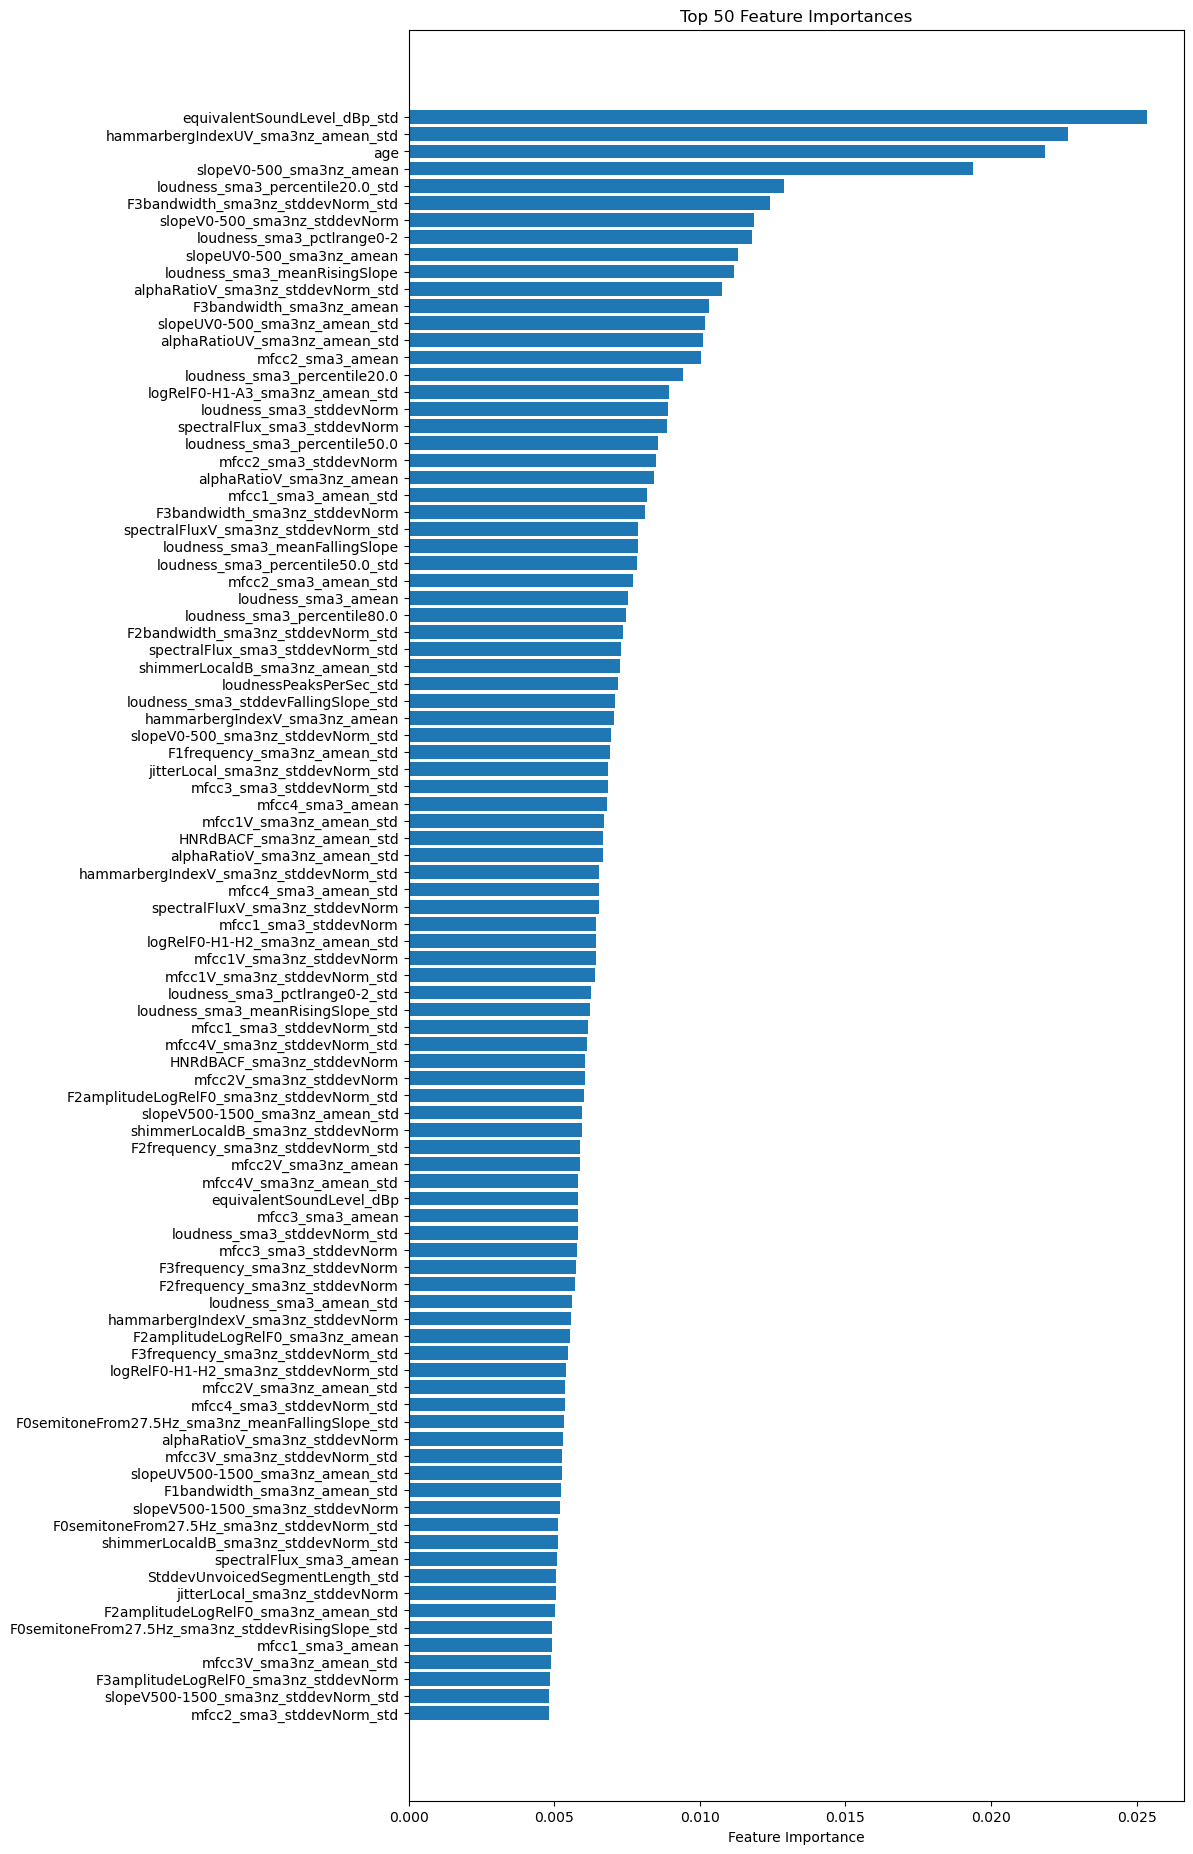

In [18]:
# feature importance
feature_importances = model.feature_importances_
feature_names = train_by_uid.columns
sorted_idx = np.argsort(feature_importances)[::-1]
top_n = 94
top_idx = sorted_idx[:top_n]
plt.figure(figsize=(10, top_n//4))
plt.barh(range(top_n), feature_importances[top_idx], align='center')
plt.yticks(range(top_n), feature_names[top_idx])
plt.xlabel('Feature Importance')
plt.title('Top 50 Feature Importances')
plt.gca().invert_yaxis()  # To have the highest importance at the top
plt.show()

### 3.4. Ordinal Classification

**Ordinal Classification** is a type of machine learning task where the target variable consists of categories that have a meaningful order or ranking, but the differences between the categories are not necessarily uniform. In other words, the classes are ordered, but the exact distance between them is not known or assumed to be equal. In contrast, multi-class classification ignores this ordering relationship.

In our data, we have three classes (Health, MCI, and Alzheimer's Disease) with a natural order where: Health (0) < MCI (1) < Alzheimer's (2). 

However, while the classes have an inherent ordering (i.e., Alzheimer's is worse than MCI, which is worse than Health), the "distance" between each class is not explicitly defined. For example, the difference between Health and MCI may not be the same as between MCI and Alzheimer's, and we don't know how to quantify these differences precisely.

**Key Characteristics of Ordinal Classification:**
- **Ordered Labels:** Classes have an inherent order (e.g., health < MCI < Alzheimer's).
- **Non-Uniform Distance:** The difference between categories is not necessarily equal or quantifiable, making this different from regression tasks where continuous values are predicted.
- **Loss Function:** In ordinal classification, specialized loss functions like **Ordinal Cross-Entropy Loss** can be used to penalize predictions that are far from the correct class based on the order.

**How it Differs from Other Types of Classification:**
- **Binary Classification:** There are only two categories (e.g., healthy vs. diseased), with no inherent order between classes.
- **Multiclass Classification:** The classes are distinct, but there’s no order. For example, classifying animals into categories like "dog," "cat," and "bird" is multiclass but not ordinal, as there’s no ranking between the classes.

In summary, ordinal classification helps in cases like AD diagnosis, where you want to predict stages of a disease that have a clear, ordered progression, but the precise difference between stages isn't easily quantifiable.

In [19]:
# Implementation from https://www.kaggle.com/code/jayahn0104/ordinal-classification-tune-sklearn-skorch
from sklearn.base import BaseEstimator
from sklearn.base import clone
from sklearn.metrics import accuracy_score

class OrdinalClassifier(BaseEstimator):

    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}

    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                try:
                  clf.module
                except: # For others
                  clf.fit(X, binary_y)
                else: # For MLP
                  binary_y_reshape = binary_y.astype('float32').reshape(-1,1)
                  clf.fit(X, binary_y_reshape)
                self.clfs[i] = clf

    def predict_proba(self, X):
        clfs_predict = {k: self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i, y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[i][:,1])
            elif i in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[i-1][:,1] - clfs_predict[i][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[i-1][:,1])
        try:
          self.clf.module
        except: # For others
          pred_proba = np.vstack(predicted).T      
        else: # For MLP
          pred_proba = np.hstack((predicted))
        
        return pred_proba

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def score(self, X, y, sample_weight=None):
        _, indexed_y = np.unique(y, return_inverse=True)
        return accuracy_score(indexed_y, self.predict(X), sample_weight=sample_weight)

In [20]:
model = OrdinalClassifier(
    # RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_leaf=10, criterion="log_loss")
    # XGBClassifier(random_state=42)
    LogisticRegression(max_iter=1000, random_state=42),
    # LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state=42)
    # OneVsRestClassifier(SVC(kernel='linear', random_state=42, probability=True))
)
model.fit(X_train, y_train_onecol)

# train 
y_proba = model.predict_proba(X_train)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_train, y_pred)
loss = log_loss(y_train, y_proba)
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Training Log Loss: {loss:.4f}')

# val 
y_proba = model.predict_proba(X_val)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_proba)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Log Loss: {loss:.4f}')

Training Accuracy: 0.6839
Training Log Loss: 0.6729
Validation Accuracy: 0.6545
Validation Log Loss: 1.1955


### 3.5. Dimension Reduction

#### Principal Component Analysis

**Principal Component Analysis (PCA)** is a technique for reducing the dimensionality of data by transforming it into a set of orthogonal (uncorrelated) variables called principal components, which capture the most variance in the data. PCA helps simplify data while preserving as much information as possible, making it easier to visualize and analyze.

In [21]:
n_components = 10
pca = PCA(n_components=n_components)  # Set the number of components you want (e.g., 2)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

Explained Variance Ratio: [0.34267493 0.18194844 0.0743768  0.06459742 0.03341604 0.02126347
 0.01716451 0.01448116 0.01280458 0.01134941]


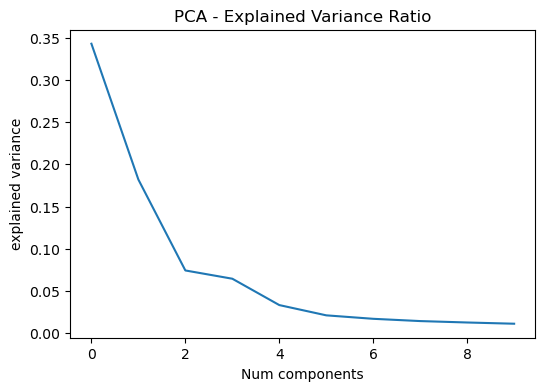

In [22]:
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
plt.figure(figsize=(6,4))
plt.plot(pca.explained_variance_ratio_)
plt.title('PCA - Explained Variance Ratio')
plt.xlabel('Num components')
plt.ylabel('explained variance')
plt.show()

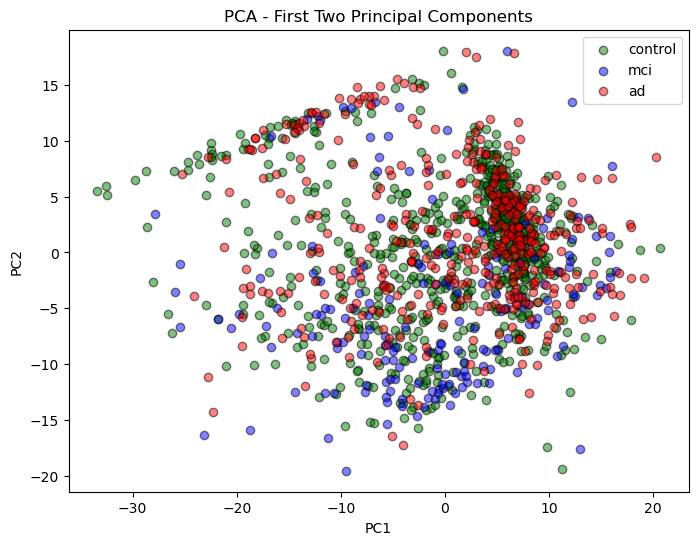

In [23]:
plt.figure(figsize=(8, 6))
idx0 = np.where(y_train_onecol==0)[0]
idx1 = np.where(y_train_onecol==1)[0]
idx2 = np.where(y_train_onecol==2)[0]
plt.scatter(X_train_pca[idx0,0], X_train_pca[idx0,1], c='green', edgecolor='k', alpha=0.5, label="control")
plt.scatter(X_train_pca[idx1,0], X_train_pca[idx1,1], c='blue', edgecolor='k', alpha=0.5, label="mci")
plt.scatter(X_train_pca[idx2,0], X_train_pca[idx2,1], c='red', edgecolor='k', alpha=0.5, label="ad")
plt.title('PCA - First Two Principal Components')
plt.xlabel('PC1')
plt.legend()
plt.ylabel('PC2')
plt.show()

In [25]:
# classification 
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=20, min_samples_leaf=1, criterion="log_loss")
model.fit(X_train_pca, y_train)

# val 
y_pred = model.predict(X_val_pca)
y_proba = model.predict_proba(X_val_pca)
y_proba = np.stack([y_proba[i][:, 1] for i in range(len(y_proba))]).T
accuracy = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_proba)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Log Loss: {loss:.4f}')

# train 
y_pred = model.predict(X_train_pca)
y_proba = model.predict_proba(X_train_pca)
y_proba = np.stack([y_proba[i][:, 1] for i in range(len(y_proba))]).T
accuracy = accuracy_score(y_train, y_pred)
loss = log_loss(y_train, y_proba)
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Training Log Loss: {loss:.4f}')

Validation Accuracy: 0.5394
Validation Log Loss: 0.8058
Training Accuracy: 1.0000
Training Log Loss: 0.2154


#### Partial Least Squares

**Partial Least Squares (PLS)** is a dimension reduction technique that finds the underlying relationships between two datasets by projecting them into a lower-dimensional space, maximizing the covariance between the features and the target variable. PLS is particularly useful when dealing with multicollinearity or when the number of predictors exceeds the number of observations.

In [30]:
n_components = 20
pls = PLSRegression(n_components=n_components)
X_train_pls = pls.fit_transform(X_train, y_train_onecol)[0]
X_val_pls = pls.transform(X_val)
X_test_pls = pls.transform(X_test)

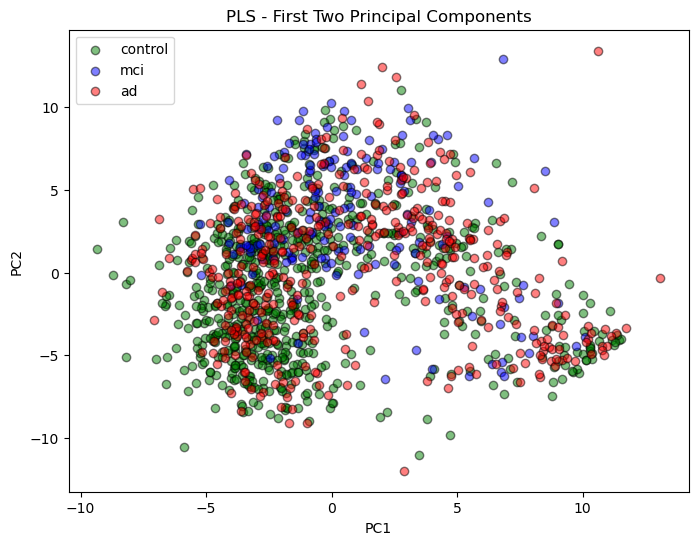

In [31]:
plt.figure(figsize=(8, 6))
idx0 = np.where(y_train_onecol==0)[0]
idx1 = np.where(y_train_onecol==1)[0]
idx2 = np.where(y_train_onecol==2)[0]
plt.scatter(X_train_pls[idx0,0], X_train_pls[idx0,1], c='green', edgecolor='k', alpha=0.5, label="control")
plt.scatter(X_train_pls[idx1,0], X_train_pls[idx1,1], c='blue', edgecolor='k', alpha=0.5, label="mci")
plt.scatter(X_train_pls[idx2,0], X_train_pls[idx2,1], c='red', edgecolor='k', alpha=0.5, label="ad")
plt.title('PLS - First Two Principal Components')
plt.xlabel('PC1')
plt.legend()
plt.ylabel('PC2')
plt.show()

In [32]:
# classification 
model = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=20, min_samples_leaf=1, criterion="log_loss")
model.fit(X_train_pls, y_train)

# val 
y_pred = model.predict(X_val_pls)
y_proba = model.predict_proba(X_val_pls)
y_proba = np.stack([y_proba[i][:, 1] for i in range(len(y_proba))]).T
accuracy = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_proba)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Log Loss: {loss:.4f}')

# train 
y_pred = model.predict(X_train_pls)
y_proba = model.predict_proba(X_train_pls)
y_proba = np.stack([y_proba[i][:, 1] for i in range(len(y_proba))]).T
accuracy = accuracy_score(y_train, y_pred)
loss = log_loss(y_train, y_proba)
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Training Log Loss: {loss:.4f}')

Validation Accuracy: 0.5515
Validation Log Loss: 0.7708
Training Accuracy: 1.0000
Training Log Loss: 0.2065


## Part 4: Late Fusion: Majority Voting

We performed segment-level classification and counted the number of segments identified as AD and non-AD for each subject. The final label for each subject was then assigned based on a majority vote, determining whether the majority of segments indicated AD or non-AD.

Advantages
* Significantly increased sample size reduces overfitting
* The majority voting effectively accounts for variability across segments to make a robust prediction decision

Limitations:
* However, each of the 0.2s segments may not contain enough information for the model to learn

We implement a function to ensemble predictions. It has three options:
* Mean of the predictions
* Median of predictions 
* Ensemble based on confidence of the softmax

In [35]:
def ensemble_predictions(y_proba_df, train_patients, confidence_gap_thd=0.5, method="confidence"):
    
    if method == "confidence":
        y_proba_df.index.name="uid"
        y_proba = pd.DataFrame(index=train_patients, columns=y_proba_df.columns)
        n_confident = 0 
        for uid in train_patients:
            dat = np.asarray(y_proba_df.loc[uid])
            mean_class = y_proba_df.loc[uid].median(axis=0)
            confidence_gap = max(mean_class) - min(mean_class)
            ensemble = np.asarray(mean_class) 
            if confidence_gap > confidence_gap_thd:
                n_confident += 1 
                ensemble[np.argmax(mean_class)] = np.max(dat[:, np.argmax(mean_class)])
                ensemble[np.argmin(mean_class)] = np.min(dat[:, np.argmin(mean_class)])
            y_proba.loc[uid] = ensemble
        print(f"There were {n_confident} high confidence samples based on threshodl {confidence_gap_thd}")
        
    elif method == "mean":
        y_proba = y_proba_df.groupby(y_proba_df.index).mean()
    
    elif method == "median":
        y_proba = y_proba_df.groupby(y_proba_df.index).median()
        
    y_proba = np.asarray(y_proba.loc[train_patients])
    
    # normalize
    y_proba = y_proba / y_proba.sum(axis=1, keepdims=True)
    
    return y_proba

#### Data prep

In [77]:
train_y_segment = train.reset_index()[["uid"]].merge(train_y, on="uid")
if 'segment_start_sec' in train.columns:
    train.drop(['segment_start_sec', 'segment_end_sec'], axis=1, inplace=True)
    test.drop(['segment_start_sec', 'segment_end_sec'], axis=1, inplace=True)
if 'uid' in train_y_segment.columns:
    train_y_segment.set_index("uid", inplace=True)
train_y_segment.shape, train.shape

((444694, 3), (444694, 94))

In [78]:
# split (better is KFold CV)
train_patients, val_patients = train_test_split(patients, test_size=VAL_SIZE, random_state=42)

X_train = train.loc[train_patients]
y_train = np.asarray(train_y.loc[train_patients])
y_train_segment = np.asarray(train_y_segment.loc[train_patients])
X_val = train.loc[val_patients]
y_val = np.asarray(train_y.loc[val_patients])
y_val_segment = np.asarray(train_y_segment.loc[val_patients])

X_test = test
y_train_onecol = np.argmax(y_train_segment, axis=1)
y_val_onecol = np.argmax(y_val_segment, axis=1)

train_ids = train_y_segment.loc[train_patients].index.tolist()
val_ids = train_y_segment.loc[val_patients].index.tolist()
test_ids = test_by_uid.index.tolist()

y_train_all_onecol = np.argmax(np.asarray(train_y_segment), axis=1)
X_train_all = train
patients_all = train.index.tolist()

X_train.shape, X_val.shape, y_train_segment.shape, y_val_segment.shape, X_test.shape, y_train_all_onecol.shape, X_train_all.shape

((356173, 94),
 (88521, 94),
 (356173, 3),
 (88521, 3),
 (111068, 94),
 (444694,),
 (444694, 94))

In [79]:
# seprate contiuous and categorical features 
X_train_categ = X_train.loc[:, covariates]
X_train_continous = X_train.loc[:, ~X_train.columns.isin(covariates)]
X_val_categ = X_val.loc[:, covariates]
X_val_continous = X_val.loc[:, ~X_val.columns.isin(covariates)]
X_train_all_categ = X_train_all.loc[:, covariates]
X_train_all_continous = X_train_all.loc[:, ~X_train_all.columns.isin(covariates)]
X_test_categ = X_test.loc[:, covariates]
X_test_continous = X_test.loc[:, ~X_test.columns.isin(covariates)]

# standardize continous variables 
scaler = StandardScaler()
X_train_continous = scaler.fit_transform(X_train_continous)
X_val_continous = scaler.transform(X_val_continous)
X_train_all_continous = scaler.fit_transform(X_train_all_continous)
X_test_continous = scaler.transform(X_test_continous)

# put back
X_train = np.concatenate([X_train_continous, X_train_categ], axis=1)
X_val = np.concatenate([X_val_continous, X_val_categ], axis=1)
X_train_all = np.concatenate([X_train_all_continous, X_train_all_categ], axis=1)
X_test = np.concatenate([X_test_continous, X_test_categ], axis=1)
X_train.shape, X_val.shape, X_train_all.shape, X_test.shape

((356173, 94), (88521, 94), (444694, 94), (111068, 94))

### Logistic Regression

In [207]:
model = LogisticRegression(max_iter=1000, random_state=42, multi_class="auto")
model.fit(X_train, y_train_onecol)

# train 
y_proba = model.predict_proba(X_train)
y_proba_df = pd.DataFrame(y_proba, index=train_ids, columns=["healthy","MCI","AD"])
# group by segment into patient-level by median, make sure order of patients is still the same 
y_proba = np.asarray(y_proba_df.groupby(y_proba_df.index).median().loc[train_patients]) 
y_proba = y_proba / y_proba.sum(axis=1, keepdims=True) # noramlize 
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_train, y_pred)
loss = log_loss(y_train, y_proba)
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Training Log Loss: {loss:.4f}')

# val 
y_proba = model.predict_proba(X_val)
y_proba_df = pd.DataFrame(y_proba, index=val_ids, columns=["healthy","MCI","AD"])
# group by segment into patient-level by median, make sure order of patients is still the same 
y_proba = np.asarray(y_proba_df.groupby(y_proba_df.index).median().loc[val_patients]) 
y_proba = y_proba / y_proba.sum(axis=1, keepdims=True) # noramlize 
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_proba)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Log Loss: {loss:.4f}')

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Accuracy: 0.5540
Training Log Loss: 0.8946
Validation Accuracy: 0.6121
Validation Log Loss: 0.8611


/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [111]:
model = RandomForestClassifier(random_state=42, n_estimators=100)

params = {
    'max_depth': [None, 10, 20, 30, 40],  # Depth of trees
    'min_samples_split': [2, 5, 10, 20],  # Minimum number of samples required to split a node
    'min_samples_leaf': [3, 5, 10, 20],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True],  # Whether bootstrap samples are used when building trees
}

In [ ]:
# takes more than 3 hours to run!!
search = RandomizedSearchCV(
    model, param_distributions=params, random_state=42, n_iter=200, 
    cv=3, verbose=1, n_jobs=1, return_train_score=True
)
search.fit(X_train, y_train_onecol)
report_best_scores(search.cv_results_, 1)
model = search.best_estimator_


In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train_onecol)

In [ ]:
### weighted ensemble based on confidence
ensemble_method = "median" # "mean"
confidence_gap_thd = 0.5

# train 
y_proba = model.predict_proba(X_train)
y_proba_df = pd.DataFrame(y_proba, index=train_ids, columns=["healthy","MCI","AD"])
y_proba = ensemble_predictions(y_proba_df, train_patients, confidence_gap_thd, ensemble_method)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_train, y_pred)
loss = log_loss(y_train, y_proba)
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Training Log Loss: {loss:.4f}')

# val 
y_proba = model.predict_proba(X_val)
y_proba_df = pd.DataFrame(y_proba, index=val_ids, columns=["healthy","MCI","AD"])
y_proba = ensemble_predictions(y_proba_df, val_patients, confidence_gap_thd, ensemble_method)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_proba)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Log Loss: {loss:.4f}')


Training Accuracy: 1.0000
Training Log Loss: 0.1492
Validation Accuracy: 0.6322
Validation Log Loss: 0.7390


In [419]:
### weighted ensemble based on confidence
ensemble_method = "mean" # "mean"
confidence_gap_thd = 0.5

# train 
y_proba = model.predict_proba(X_train)
y_proba_df = pd.DataFrame(y_proba, index=train_ids, columns=["healthy","MCI","AD"])
y_proba = ensemble_predictions(y_proba_df, train_patients, confidence_gap_thd, ensemble_method)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_train, y_pred)
loss = log_loss(y_train, y_proba)
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Training Log Loss: {loss:.4f}')

# val 
y_proba = model.predict_proba(X_val)
y_proba_df = pd.DataFrame(y_proba, index=val_ids, columns=["healthy","MCI","AD"])
y_proba = ensemble_predictions(y_proba_df, val_patients, confidence_gap_thd, ensemble_method)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_proba)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Log Loss: {loss:.4f}')


Training Accuracy: 1.0000
Training Log Loss: 0.1576
Validation Accuracy: 0.6444
Validation Log Loss: 0.7430


In [427]:
### weighted ensemble based on confidence
ensemble_method = "confidence" # "mean"
confidence_gap_thd = 0.6

# train 
y_proba = model.predict_proba(X_train)
y_proba_df = pd.DataFrame(y_proba, index=train_ids, columns=["healthy","MCI","AD"])
y_proba = ensemble_predictions(y_proba_df, train_patients, confidence_gap_thd, ensemble_method)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_train, y_pred)
loss = log_loss(y_train, y_proba)
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Training Log Loss: {loss:.4f}')

# val 
y_proba = model.predict_proba(X_val)
y_proba_df = pd.DataFrame(y_proba, index=val_ids, columns=["healthy","MCI","AD"])
y_proba = ensemble_predictions(y_proba_df, val_patients, confidence_gap_thd, ensemble_method)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_proba)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Log Loss: {loss:.4f}')


There were 1303 high confidence samples based on threshodl 0.6
Training Accuracy: 1.0000
Training Log Loss: 0.1099
There were 145 high confidence samples based on threshodl 0.6
Validation Accuracy: 0.6322
Validation Log Loss: 0.8356


In [426]:
### weighted ensemble based on confidence
ensemble_method = "confidence" # "mean"
confidence_gap_thd = 0.7

# train 
y_proba = model.predict_proba(X_train)
y_proba_df = pd.DataFrame(y_proba, index=train_ids, columns=["healthy","MCI","AD"])
y_proba = ensemble_predictions(y_proba_df, train_patients, confidence_gap_thd, ensemble_method)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_train, y_pred)
loss = log_loss(y_train, y_proba)
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Training Log Loss: {loss:.4f}')

# val 
y_proba = model.predict_proba(X_val)
y_proba_df = pd.DataFrame(y_proba, index=val_ids, columns=["healthy","MCI","AD"])
y_proba = ensemble_predictions(y_proba_df, val_patients, confidence_gap_thd, ensemble_method)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_proba)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Log Loss: {loss:.4f}')


There were 1250 high confidence samples based on threshodl 0.7
Training Accuracy: 1.0000
Training Log Loss: 0.1145
There were 90 high confidence samples based on threshodl 0.7
Validation Accuracy: 0.6322
Validation Log Loss: 0.7352


In [424]:
### weighted ensemble based on confidence
ensemble_method = "confidence" # "mean"
confidence_gap_thd = 0.8

# train 
y_proba = model.predict_proba(X_train)
y_proba_df = pd.DataFrame(y_proba, index=train_ids, columns=["healthy","MCI","AD"])
y_proba = ensemble_predictions(y_proba_df, train_patients, confidence_gap_thd, ensemble_method)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_train, y_pred)
loss = log_loss(y_train, y_proba)
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Training Log Loss: {loss:.4f}')

# val 
y_proba = model.predict_proba(X_val)
y_proba_df = pd.DataFrame(y_proba, index=val_ids, columns=["healthy","MCI","AD"])
y_proba = ensemble_predictions(y_proba_df, val_patients, confidence_gap_thd, ensemble_method)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_proba)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Log Loss: {loss:.4f}')


There were 804 high confidence samples based on threshodl 0.8
Training Accuracy: 1.0000
Training Log Loss: 0.1362
There were 16 high confidence samples based on threshodl 0.8
Validation Accuracy: 0.6322
Validation Log Loss: 0.7378


In [425]:
### weighted ensemble based on confidence
ensemble_method = "confidence" # "mean"
confidence_gap_thd = 0.9

# train 
y_proba = model.predict_proba(X_train)
y_proba_df = pd.DataFrame(y_proba, index=train_ids, columns=["healthy","MCI","AD"])
y_proba = ensemble_predictions(y_proba_df, train_patients, confidence_gap_thd, ensemble_method)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_train, y_pred)
loss = log_loss(y_train, y_proba)
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Training Log Loss: {loss:.4f}')

# val 
y_proba = model.predict_proba(X_val)
y_proba_df = pd.DataFrame(y_proba, index=val_ids, columns=["healthy","MCI","AD"])
y_proba = ensemble_predictions(y_proba_df, val_patients, confidence_gap_thd, ensemble_method)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_proba)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Log Loss: {loss:.4f}')


There were 352 high confidence samples based on threshodl 0.9
Training Accuracy: 1.0000
Training Log Loss: 0.1472
There were 2 high confidence samples based on threshodl 0.9
Validation Accuracy: 0.6322
Validation Log Loss: 0.7388


In [437]:
# submission
ensemble_method = "confidence" # "mean"
confidence_gap_thd = 0.8

# model.fit(X_train_all, y_train_all_onecol)

# train 
y_proba = model.predict_proba(X_train_all)
y_proba_df = pd.DataFrame(y_proba, index=patients_all, columns=["healthy","MCI","AD"])
y_proba = ensemble_predictions(y_proba_df, patients, confidence_gap_thd, ensemble_method)
y_pred = np.zeros_like(y_proba, dtype=int)
y_pred[np.arange(y_proba.shape[0]), np.argmax(y_proba, axis=1)] = 1
accuracy = accuracy_score(y_train_all, y_pred)
loss = log_loss(y_train_all, y_proba)
print(f'Training Accuracy: {accuracy:.4f}')
print(f'Training Log Loss: {loss:.4f}')

# test 
test_patients = sub.index
y_proba = model.predict_proba(X_test)
y_proba_df = pd.DataFrame(y_proba, index=test.index, columns=["healthy","MCI","AD"])
y_proba = ensemble_predictions(y_proba_df, test_patients, confidence_gap_thd, ensemble_method)

There were 979 high confidence samples based on threshodl 0.8
Training Accuracy: 1.0000
Training Log Loss: 0.1402
There were 21 high confidence samples based on threshodl 0.8


In [ ]:
# # visualize distribution of predictions
num_patients = 10
fig, axes = plt.subplots(num_patients, 1, figsize=(5, num_patients * 3))
unique_patients = np.unique(y_proba_df.index)
for i, patient_index in enumerate(range(num_patients)):
    patient_data = y_proba_df.loc[unique_patients[i]]
    axes[i].hist(patient_data["AD"], bins=10, alpha=0.5, label="AD")
    axes[i].hist(patient_data["MCI"], bins=10, alpha=0.5, label="MCI")
    axes[i].hist(patient_data["healthy"], bins=10, alpha=0.5, label="Healthy")
    axes[i].set_title(f"Segment-level predictions for {y_proba_df.index[patient_index]}")
plt.legend()
plt.tight_layout()
plt.show()

## Part 5: Early Fusion: Clustering of Segments

Alternatively, we can assume that not all of a participant's 300 segments are equally useful. One approach is to cluster the segments into \(k\) clusters, where each cluster represents a distinct group of acoustic features. By sorting the clusters based on the number of segments in each, we can identify the main cluster and a supplementary cluster. In this analysis, we set \(k = 2\) to capture the primary cluster of relevant features and a secondary cluster that may contain additional acoustic information.

### Data prep

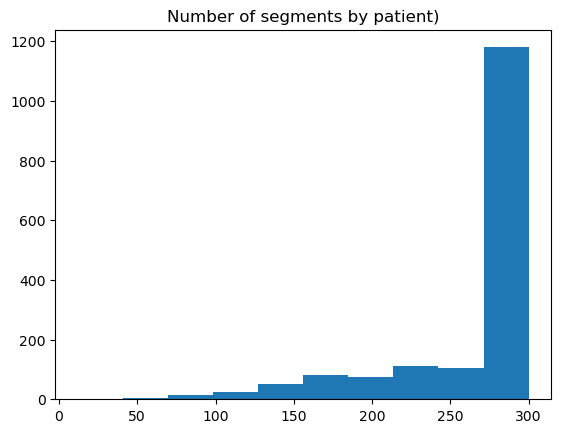

In [38]:
# visualize number of segments by participant
plt.hist(train[['segment_start_sec']].groupby(["uid"]).count())
plt.title("Number of segments by patient)")
plt.show()

In [39]:
covariates = ['gender', 'age', 'langage_en', 'langage_es','langage_gl', 'langage_zh']
features = train.columns[~train.columns.isin(covariates)].tolist()
len(covariates), len(features)

(6, 90)

In [40]:
# standardize continous variables 
X_train_continous = train.loc[:, features]
X_test_continous = test.loc[:, features]

scaler = StandardScaler()
X_train_continous = scaler.fit_transform(X_train_continous)
X_test_continous = scaler.transform(X_test_continous)

# put back
train.loc[:, features] = X_train_continous
test.loc[:, features] = X_test_continous

### Clustering

In [ ]:
k = 2 # number of segment clusters 

In [ ]:
train_patients = train_y.index.tolist()
kmeans = KMeans(n_clusters=k, random_state=42)
train_cluster = pd.DataFrame(index=train_patients)

for uid in train_patients:
    
    # run kmeans clustering 
    dat = np.asarray(train.loc[uid, features])
    cluster_labels = kmeans.fit_predict(dat)
    
    # sort labels by number of samples  
    label_counts = pd.Series(cluster_labels).value_counts()
    sorted_labels = label_counts.sort_values(ascending=False)
    
    # compute average cluster values 
    for i in range(len(sorted_labels.index)):
        feature_names = [col + "_cluster" + str(i) for col in features]
        cluster_data = dat[np.where(cluster_labels == sorted_labels.index[i])[0]]
        cluster_average = cluster_data.mean(axis=0)
        train_cluster.loc[uid, feature_names] = cluster_average
        
train_cluster.index.name = "uid"
train_cluster = train_cluster.merge(train[covariates].groupby("uid").first(), on="uid", how="left")

In [ ]:
test_patients = sub.index.tolist()
kmeans = KMeans(n_clusters=k, random_state=42)
test_cluster = pd.DataFrame(index=test_patients)

for uid in test_patients:
    
    # run kmeans clustering 
    dat = np.asarray(test.loc[uid, features])
    cluster_labels = kmeans.fit_predict(dat)
    
    # sort labels by number of samples  
    label_counts = pd.Series(cluster_labels).value_counts()
    sorted_labels = label_counts.sort_values(ascending=False)

    # compute average cluster values 
    for i in range(len(sorted_labels.index)):
        feature_names = [col + "_cluster" + str(i) for col in features]
        cluster_data = dat[np.where(cluster_labels == sorted_labels.index[i])[0]]
        cluster_average = cluster_data.mean(axis=0)
        test_cluster.loc[uid, feature_names] = cluster_average
    
test_cluster.index.name = "uid"
test_cluster = test_cluster.merge(test[covariates].groupby("uid").first(), on="uid", how="left")

In [ ]:
# split 
selected_features = [col for col in train_cluster.columns if ("cluster" in col) or (col in covariates)]
train_patients_all = train_y.index.tolist()
train_patients, val_patients = train_test_split(train_patients_all, test_size=VAL_SIZE, random_state=42)

X_train = np.asarray(train_cluster.loc[train_patients, selected_features])
y_train = np.asarray(train_y.loc[train_patients])
X_val = np.asarray(train_cluster.loc[val_patients, selected_features])
y_val = np.asarray(train_y.loc[val_patients])
y_train_onecol = np.argmax(y_train, axis=1)
y_val_onecol = np.argmax(y_val, axis=1)

X_test = np.asarray(test_cluster.loc[:, selected_features])
X_train_all = np.asarray(train_cluster.loc[:, selected_features])
y_train_all = np.asarray(train_y)

X_train.shape, X_val.shape, X_test.shape,  X_train_all.shape

((1313, 182), (329, 182), (412, 182), (1642, 182))

### Classification

In [ ]:
# data 
X_ttrain, y_ttrain =  X_train, y_train_onecol # all samples 
print("Number of samples in training:", X_ttrain.shape[0])

# train model 
model = RandomForestClassifier(
    n_estimators=100, random_state=42, max_depth=10, min_samples_leaf=10, criterion="log_loss",
    class_weight={0: 1, 1: 1, 2: 1}
)
# model = XGBClassifier(
#     random_state=42, objective="multi:softprob",
#     #class_weight={0: 1, 1: 1, 2: 1}
# )
model.fit(X_ttrain, y_ttrain)

# train 
y_proba = model.predict_proba(X_ttrain)
y_pred = model.predict(X_ttrain)
accuracy = accuracy_score(y_ttrain, y_pred)
loss = log_loss(y_ttrain, y_proba)
print(f'Training Accuracy: {accuracy:.4f} Log Loss: {loss:.4f}')

# val 
y_proba = model.predict_proba(X_val)# [:,:-4]
y_pred = model.predict(X_val)  ## [:,:-4]
accuracy = accuracy_score(y_val_onecol, y_pred)
loss = log_loss(y_val, y_proba)
print(f'Validation Accuracy: {accuracy:.4f} Log Loss: {loss:.4f}')

Number of samples in training: 1313
Training Accuracy: 0.8355 Log Loss: 0.5902
Validation Accuracy: 0.5927 Log Loss: 0.8138
Validation Accuracy English: 0.5992 Log Loss English: 0.7686
Validation Accuracy Spanish: 0.6316 Log Loss Spanish: 0.9207
